In [1]:
# Copyright © 2020, Johan Vonk
# SPDX-License-Identifier: MIT

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from sklearn.manifold import MDS
from sklearn.metrics import pairwise_distances
import paho.mqtt.client as mqtt
from threading import Timer
import json
from config import username, password
import seaborn as sns
import plotly.express as px
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow_addons as tfa
import random

In [3]:
df=pd.read_csv('pact_20200703T210016.csv')
df['POWER']=10**((11.5511+df['TX POWER']-df['RSSI'])/20)
df['RADIATION']=0.234897256+0.732700955*np.cos(np.pi/12*(((pd.to_datetime(df['TIMESTAMP'])-pd.Timestamp('13:13:02'))/pd.Timedelta(hours=1)).mod(24)))

In [170]:
test_distances=np.sort(df['DISTANCE'].unique())[[2,5,10,16,19]]
mask=df['DISTANCE'].isin(test_distances)
test_df=df.loc[mask]
train_df=df.loc[~mask]

In [179]:
X_train = pd.DataFrame([train_df['POWER']]).T
y_train = np.ravel(train_df['DISTANCE'])
X_test = pd.DataFrame([test_df['POWER']]).T
y_test = np.ravel(test_df['DISTANCE'])

In [180]:
huber=tf.keras.losses.Huber(delta=5.0)

In [181]:
model = Sequential()
model.add(Dense(8, kernel_initializer='normal', activation='swish', input_shape=(1,)))
model.add(Dense(8, kernel_initializer='normal', activation='swish'))
model.add(Dense(1, kernel_initializer='normal', activation='swish'))
model.compile(loss=huber,
              optimizer='adam',
              metrics=['mse','mae','logcosh','mape','msle'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 8)                 16        
_________________________________________________________________
dense_14 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 9         
Total params: 97
Trainable params: 97
Non-trainable params: 0
_________________________________________________________________


In [182]:
history = model.fit(X_train, y_train, epochs=8, batch_size=32, verbose=0, callbacks=[tfa.callbacks.TQDMProgressBar(), tf.keras.callbacks.ReduceLROnPlateau(factor=0.2, patience=4)], validation_data=(X_test, y_test))

Epoch 1/8



Epoch 2/8



Epoch 3/8



Epoch 4/8



Epoch 5/8



Epoch 6/8



Epoch 7/8



Epoch 8/8


In [183]:
model.save('model-rssi-time-3')

INFO:tensorflow:Assets written to: model-rssi-time-3\assets


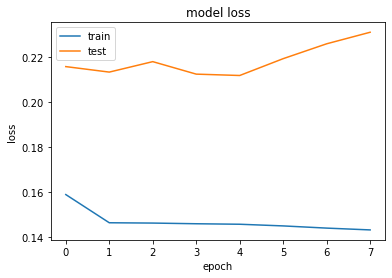

In [186]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

In [185]:
X_predict=pd.DataFrame([df['POWER']]).T
df['PREDICTION']=model.predict(X_predict, verbose=1)

21747/21747 [==============================] - 37s 2ms/step


In [187]:
y_predict=model.predict(X_test,verbose=1)

4004/4004 [==============================] - 6s 2ms/step


ML model loss is 0.15899.
False positive rate is 49.700%.
True positive rate is 50.300%.


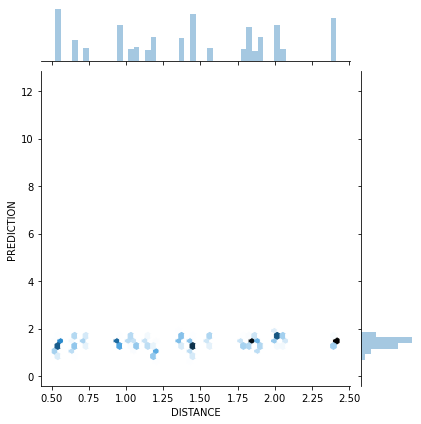

In [188]:
confusion_distance=df['DISTANCE'].mean()
graph_test=df['DISTANCE']
graph_predict=df['PREDICTION']
confusion_df=pd.DataFrame(data=tf.math.confusion_matrix(graph_test<=confusion_distance,graph_predict<=confusion_distance).numpy())
print("ML model loss is {0:.5}.".format(huber(graph_test,graph_predict).numpy()))
print("False positive rate is {0:.3%}.".format(confusion_df.loc[0,1]/(confusion_df.loc[0,1]+confusion_df.loc[1,1])))
print("True positive rate is {0:.3%}.".format(confusion_df.loc[1,1]/(confusion_df.loc[0,1]+confusion_df.loc[1,1])))
sns.jointplot(x=graph_test, y=graph_predict, kind='hex')